In [16]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import matplotlib.lines as mlines
matplotlib.rcParams['font.family'] = "monospace"
import pandas as pd 
import numpy as np
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
from matplotlib.lines import Line2D
import plotting_utils

plt.rcParams.update({
    "figure.facecolor":  (1, 1, 1, 1), 
    "axes.facecolor":    (1, 1, 1, 1), 
    "savefig.facecolor": (1, 1, 1, 1), 
})

# Helper Functions

__Performance metrics:__
- PSNR: Peak signal-to-noise ratio (expressed in devibles - noise: error introduced by compression) --> approximation to human perception of reconstruction quality --> log to MSE
- NMSE: Normalized mean-square error (normalized mean squared difference between estimated and actual values)
- SSIM: Structural similarity (between two images)

In [26]:
def get_xlim(eval_metric, df1, df2):
    min_values = [df1[eval_metric].min(), df2[eval_metric].min()]
    max_values = [df1[eval_metric].max(), df2[eval_metric].max()]

    if eval_metric == 'SSIM':
        down_lam = 0.01
        up_lam = 0.01
    elif eval_metric == 'NMSE':
        down_lam = 0.0025
        up_lam = 0.0025
    elif eval_metric == 'PSNR':
        down_lam = 2
        up_lam = 2
    else:
        lam = 0

    lower = min(min_values) - down_lam
    upper = max(max_values) + up_lam

    return [lower, upper]


def get_ticks(eval_metric, xlim):
    if eval_metric == 'SSIM':
        major_tick = 0.01
        minor_tick = 0.005
    elif eval_metric == 'NMSE':
        major_tick = round((xlim[1] - xlim[0])/10, ndigits=3)
        minor_tick = major_tick/2
    elif eval_metric == 'PSNR':
        major_tick = 1
        minor_tick = 0.5 
    else:
        major_tick = 0
        minor_tick = 0  
        
    return major_tick, minor_tick

# Modified version 
def get_plotting_data_df(df, network_keys, anatomy_keys, eval_metric, network_column):
    df_final = None
    cols = [network_column, 'dset', eval_metric, eval_metric+'_std']
    for nkey in network_keys:
        for ecol in anatomy_keys:
            df_eval = df[df[network_column]==nkey]
            row = [f'{nkey.ljust(10)}', f'{ecol.ljust(14)}']
            count = df_eval[df_eval['anatomy']==ecol].count()[eval_metric]
            metric_mean = df_eval[df_eval['anatomy']==ecol].mean()[eval_metric]
            metric_std = df_eval[df_eval['anatomy']==ecol].std()[eval_metric]
            row.append(metric_mean)
            row.append(metric_std)

            df_eval = pd.DataFrame([row], columns=cols)
            df_final = pd.concat([df_final, df_eval], ignore_index=True)
            x = df_final
            #x = df_final.set_index(network_column)[eval_metric]#.sort_values(ascending=True)
            #y = df_final.set_index('dset')[eval_metric].sort_values(ascending=True)

    return x


def get_color(elems):
    cmap = plt.cm.tab20c
    color = []
    for elem in elems:
        if 'GD-DUNET' in elem:
            color.append("silver")
        elif 'PM-DUNET' in elem:
            color.append(cmap(2*4/20))
        elif 'VS-DUNET' in elem:
            color.append(cmap(1/5))
        elif 'UNET' in elem:
            color.append("purple")
        elif 'VN' in elem:
            color.append("blue")
        elif 'MoDL' in elem:
            color.append("red")
        else:
            color.append("black")

    return color


def get_edge_color(dset):
    if 'knee' in dset:
        return "yellow"
    elif 'neuro' in dset: 
        return "white"
    

def get_marker(type): # markers = ["." , "," , "o" , "v" , "^" , "<", ">", '*'] 'AXFLAIR' 'AXT1POST' 'AXT1' 'AXT2']
    if type == 'AXFLAIR' or type == 'Prisma_fit':
        return "*"
    elif type == 'AXT1POST' or type == 'Skyra':
        return "o"
    elif type == 'AXT1' or type == 'Aera':
        return "v"
    elif type == 'AXT2' or type == 'Biograph_mMR':
        return "^"
    elif type == 'CORPD_FBK' or type == 'TrioTim':
        return "<"
    elif type == 'CORPDFS_FBK' or type== 'Avanto':
        return ">"   
    else:
        return ","


def get_legend(eval_dset, acq_types):
    legend_elements = []
    legend_elements.append(Patch(edgecolor="white", facecolor="white", label="neuro"))
    legend_elements.append(Patch(edgecolor="yellow", facecolor="white", label="knee"))      
    color = get_color(eval_dset)
    # add network colors
    for c, l in zip(color, eval_dset):
        legend_elements.append(Patch(facecolor=c, label=l))
    # Add acquisition type markers
    #legend_elements.append(mlines.Line2D([], [], color='black', marker="s", linestyle='None', label="Mean values")) 
    for acq_type in acq_types:
        legend_elements.append(mlines.Line2D([], [], color='black', marker=get_marker(acq_type), linestyle='None', label=acq_type))

    return legend_elements

# Get Column content

In [18]:
anatomy = 'brain'
Reval = 4

df = pd.read_csv(f'./resources/{anatomy}/eval_{anatomy}_R{Reval}.csv')

networks = df.network.unique()
acq_types = df.acquisition.unique() #acquisition types: ['AXFLAIR', 'AXT1POST', 'AXT1', 'AXT2']
scanner_models = df.systemModel.unique() #scanner models: ['Skyra' 'Aera' 'Biograph_mMR' 'Prisma_fit' 'TrioTim' 'Avanto']

print("\033[4m" + "Dataset:", anatomy, "R" + str(Reval) + "\033[0m")
print("Networks:", networks)
print("Acquisition Types:", acq_types)
print("Scanner models:", scanner_models)

Dataset: brain R4
Networks: ['GD-DUNET' 'PM-DUNET' 'VS-DUNET' 'UNET' 'VN' 'MoDL']
Acquisition Types: ['AXFLAIR' 'AXT1POST' 'AXT1' 'AXT2']
Scanner models: ['Skyra' 'Aera' 'Biograph_mMR' 'Prisma_fit' 'TrioTim' 'Avanto']


# Scatterplotting Networks

In [19]:
def get_base_data_reval_comparison(anatomy, eval_metric):
    Reval = [4, 8]

    eval_dset = ['neuro','knee 100'] # name of dataset in csv
    disp_dset = ['neuro','knee'] # display name of dataset

    df_raw = pd.read_csv(f'./resources/{anatomy}/eval_{anatomy}_R4.csv')

    networks = df_raw.network.unique()
    acq_types = df_raw.acquisition.unique() #acquisition types: ['AXFLAIR', 'AXT1POST', 'AXT1', 'AXT2']
    scanner_models = df_raw.systemModel.unique() #scanner models: ['Skyra' 'Aera' 'Biograph_mMR' 'Prisma_fit' 'TrioTim' 'Avanto']

    df = df_raw
    # evaluate wrt. SSIM and drop other measures
    drop_metric = [m for m in ['MSE', 'PSNR', 'NMSE', 'SSIM'] if m != eval_metric]
    df.drop(columns=drop_metric, inplace=True)

    # drop rows that are not of the acquisition type
    #df = df[df.network == network_type]

    network_keys = df['network'].unique()
    anatomy_keys = df['anatomy'].unique()
    # only evaluate for knee 100 (full fastMRI knee dataset) and neuro data (full fastMRI neuro dataset)
    anatomy_keys = [key for key in anatomy_keys if key in eval_dset]

    x1 = get_plotting_data_df(df, network_keys, anatomy_keys, eval_metric, network_column='network')

    df_raw = pd.read_csv(f'./resources/{anatomy}/eval_{anatomy}_R8.csv')
    df = df_raw
    model_keys = df['systemModel'].unique()
    df.drop(columns=drop_metric, inplace=True)

    x2 = get_plotting_data_df(df, network_keys, anatomy_keys, eval_metric, network_column='network')

    return x1, x2

[0.8236296497809189, 0.9767140927504149]
['GD-DUNET', 'PM-DUNET', 'VS-DUNET', 'UNET', 'VN', 'MoDL']


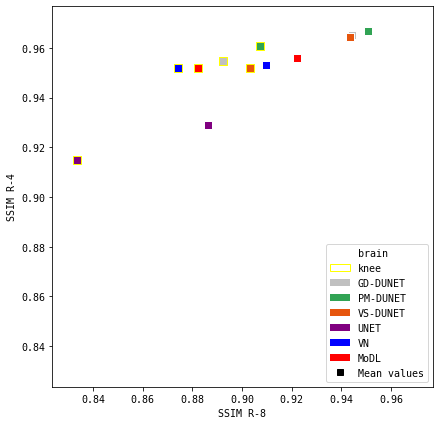

In [78]:
eval_metric = "SSIM"

x1, x2 = get_base_data_reval_comparison("brain", eval_metric)

xlim = get_xlim(eval_metric, x1, x2)
print(xlim)

markers = ["." , "," , "o" , "v" , "^" , "<", ">"]

networks = [network.replace(" ", "") for network in x1.network.unique()]
print(networks)
legend = get_legend(networks, [])
cmap = plt.cm.tab20c

fig = plt.figure(figsize=(7, 7))

for row in range(len(x1)):
    r4 = x1.loc[row]["SSIM"]
    r8 = x2.loc[row]["SSIM"]
    plt.scatter(r8, r4, s=75, marker=',', color=get_color([x1.loc[row]["network"]]), edgecolor=get_edge_color(x1.loc[row]["dset"]))

plt.xlabel("SSIM R-8")
plt.axis('square')
plt.ylabel("SSIM R-4")
plt.legend(handles=legend, loc='lower right')
plt.xlim(xlim)
plt.ylim(xlim)
plt.show()

# Scatterplotting networks' performances on acquisition types

['GD-DUNET' 'PM-DUNET' 'VS-DUNET' 'UNET' 'VN' 'MoDL']
['Skyra' 'Aera' 'Biograph_mMR' 'Prisma_fit' 'TrioTim' 'Avanto']


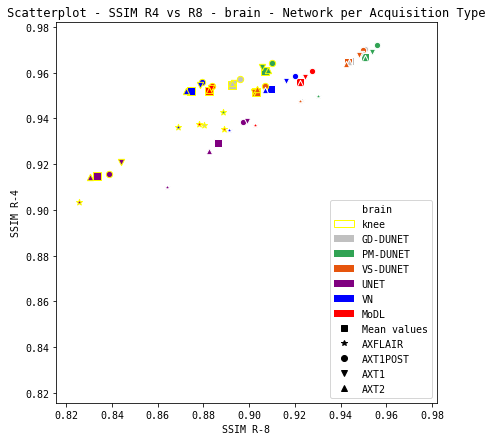

In [5]:
anatomy = 'brain'
eval_metric = 'SSIM'

x1, x2 = get_base_data_reval_comparison(anatomy, eval_metric)

eval_dset = ['neuro','knee 100'] # name of dataset in csv
disp_dset = ['neuro','knee'] # display name of dataset
fig = plt.figure(figsize=(7, 7))

df_raw_r4 = pd.read_csv(f'./resources/{anatomy}/eval_{anatomy}_R4.csv')
df_raw_r8 = pd.read_csv(f'./resources/{anatomy}/eval_{anatomy}_R8.csv')

networks = df_raw_r4.network.unique()
acq_types = df_raw_r4.acquisition.unique() #acquisition types: ['AXFLAIR', 'AXT1POST', 'AXT1', 'AXT2']
scanner_models = df_raw_r4.systemModel.unique() #scanner models: ['Skyra' 'Aera' 'Biograph_mMR' 'Prisma_fit' 'TrioTim' 'Avanto']
print(networks)
print(scanner_models)

legend = get_legend(networks, acq_types)
xlims = [get_xlim("SSIM", x1, x2)]

for row in range(len(x1)):
    r4 = x1.loc[row][eval_metric]
    r8 = x2.loc[row][eval_metric]
    plt.scatter(r8, r4, s=75, marker=',', color=get_color([x1.loc[row]["network"]]), edgecolor=get_edge_color(x1.loc[row]["dset"]))

for acq_type in acq_types:
    # get R4 data
    df_r4 = df_raw_r4
    df_r4 = df_r4[df_r4.acquisition == acq_type]

    # evaluate wrt. SSIM and drop other measures
    drop_metric = [m for m in ['MSE', 'PSNR', 'NMSE', 'SSIM'] if m != eval_metric]
    df_r4 = df_r4.drop(columns=drop_metric)

    # drop rows that are not of the acquisition type
    #df = df[df.network == network_type]
    network_keys = df_r4['network'].unique()
    anatomy_keys = df_r4['anatomy'].unique()
    model_keys = df_r4['systemModel'].unique()
    # only evaluate for knee 100 (full fastMRI knee dataset) and neuro data (full fastMRI neuro dataset)
    anatomy_keys = [key for key in anatomy_keys if key in eval_dset]
    x3 = get_plotting_data_df(df_r4, network_keys, anatomy_keys, eval_metric, network_column='network')

    # get R8 data
    df_r8 = df_raw_r8
    df_r8 = df_r8[df_r8.acquisition == acq_type]
    df_r8 = df_r8.drop(columns=drop_metric)
    x4 = get_plotting_data_df(df_r8, network_keys, anatomy_keys, eval_metric, network_column='network')

    # plot R4 and R8 data
    for row in range(len(x3)):
        r4 = x3.loc[row][eval_metric]
        r8 = x4.loc[row][eval_metric]
        plt.scatter(r8, r4, s=40, marker=get_marker(acq_type), color=get_color([x3.loc[row]["network"]]), edgecolor=get_edge_color(x3.loc[row]["dset"]))
    xlims.append(get_xlim("SSIM", x3, x4))

# calculate axis values
xlims = np.array(xlims)
xlim = [min(xlims[:,0]), max(xlims[:,1])]

# Show scatterplot
plt.title(f"Scatterplot - {eval_metric} R4 vs R8 - {anatomy} - Network per Acquisition Type")
plt.xlabel(f"{eval_metric} R-8")
plt.ylabel(f"{eval_metric} R-4")
plt.axis('square')
plt.legend(handles=legend, loc='lower right')
plt.xlim(xlim)
plt.ylim(xlim)
plt.show()

# Scatterplotting networks' performances on scanner models

['Prisma_fit' 'Skyra' 'Aera' 'Biograph_mMR']


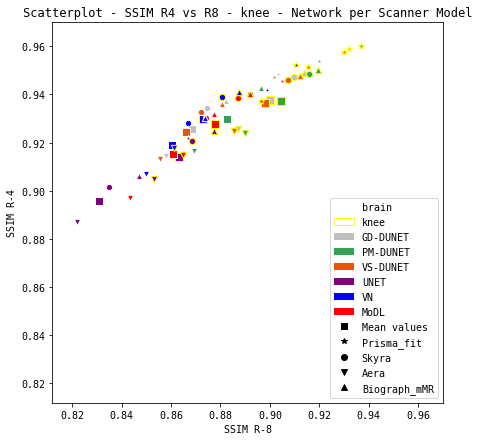

In [8]:
anatomy = 'knee'
eval_metric = 'SSIM'

x1, x2 = get_base_data_reval_comparison(anatomy, eval_metric)

eval_dset = ['neuro','knee 100'] # name of dataset in csv
disp_dset = ['neuro','knee'] # display name of dataset
fig = plt.figure(figsize=(7, 7))

df_raw_r4 = pd.read_csv(f'./resources/{anatomy}/eval_{anatomy}_R4.csv')
df_raw_r8 = pd.read_csv(f'./resources/{anatomy}/eval_{anatomy}_R8.csv')

networks = df_raw_r4.network.unique()
acq_types = df_raw_r4.acquisition.unique() #acquisition types: ['AXFLAIR', 'AXT1POST', 'AXT1', 'AXT2']
scanner_models = df_raw_r4.systemModel.unique() #scanner models: ['Skyra' 'Aera' 'Biograph_mMR' 'Prisma_fit' 'TrioTim' 'Avanto']
print(scanner_models)

legend = get_legend(networks, scanner_models)
xlims = [get_xlim(eval_metric, x1, x2)]

for row in range(len(x1)):
    r4 = x1.loc[row][eval_metric]
    r8 = x2.loc[row][eval_metric]
    plt.scatter(r8, r4, s=75, marker=',', color=get_color([x1.loc[row]["network"]]), edgecolor=get_edge_color(x1.loc[row]["dset"]))

for scanner_model in scanner_models:
    # get R4 data
    df_r4 = df_raw_r4
    df_r4 = df_r4[df_r4.systemModel == scanner_model]

    # evaluate wrt. SSIM and drop other measures
    drop_metric = [m for m in ['MSE', 'PSNR', 'NMSE', 'SSIM'] if m != eval_metric]
    df_r4 = df_r4.drop(columns=drop_metric)

    # drop rows that are not of the acquisition type
    #df = df[df.network == network_type]
    network_keys = df_r4['network'].unique()
    anatomy_keys = df_r4['anatomy'].unique()
    model_keys = df_r4['systemModel'].unique()
    # only evaluate for knee 100 (full fastMRI knee dataset) and neuro data (full fastMRI neuro dataset)
    anatomy_keys = [key for key in anatomy_keys if key in eval_dset]
    x3 = get_plotting_data_df(df_r4, network_keys, anatomy_keys, eval_metric, network_column='network')

    # get R8 data
    df_r8 = df_raw_r8
    df_r8 = df_r8[df_r8.systemModel == scanner_model]
    df_r8 = df_r8.drop(columns=drop_metric)
    x4 = get_plotting_data_df(df_r8, network_keys, anatomy_keys, eval_metric, network_column='network')

    # plot R4 and R8 data
    for row in range(len(x3)):
        r4 = x3.loc[row][eval_metric]
        r8 = x4.loc[row][eval_metric]
        plt.scatter(r8, r4, s=40, marker=get_marker(scanner_model), color=get_color([x3.loc[row]["network"]]), edgecolor=get_edge_color(x3.loc[row]["dset"]))
    xlims.append(get_xlim(eval_metric, x3, x4))

# calculate axis values
xlims = np.array(xlims)
xlim = [min(xlims[:,0]), max(xlims[:,1])]

# Show scatterplot
plt.title(f"Scatterplot - {eval_metric} R4 vs R8 - {anatomy} - Network per Scanner Model")
plt.xlabel(f"{eval_metric} R-8")
plt.ylabel(f"{eval_metric} R-4")
plt.axis('square')
plt.legend(handles=legend, loc='lower right')
plt.xlim(xlim)
plt.ylim(xlim)
plt.show()

# Scatterplotting networks' performances per acquisition type on scanner models

['AXFLAIR' 'AXT1POST' 'AXT1' 'AXT2']
['Skyra' 'Aera' 'Biograph_mMR' 'Prisma_fit' 'TrioTim' 'Avanto']


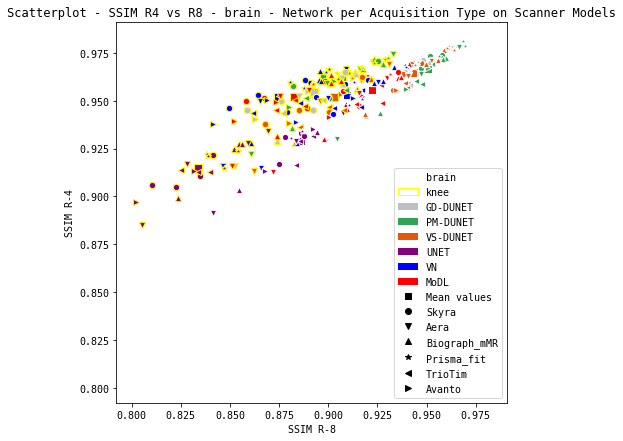

In [32]:
# Old version:

anatomy = 'brain'
eval_metric = 'SSIM'

x1, x2 = get_base_data_reval_comparison(anatomy, eval_metric)

eval_dset = ['neuro','knee 100'] # name of dataset in csv
disp_dset = ['neuro','knee'] # display name of dataset

df_raw_r4 = pd.read_csv(f'./resources/{anatomy}/eval_{anatomy}_R4.csv')
df_raw_r8 = pd.read_csv(f'./resources/{anatomy}/eval_{anatomy}_R8.csv')

networks = df_raw_r4.network.unique()
acq_types = df_raw_r4.acquisition.unique() #acquisition types: ['AXFLAIR', 'AXT1POST', 'AXT1', 'AXT2']
scanner_models = df_raw_r8.systemModel.unique() #scanner models: ['Skyra' 'Aera' 'Biograph_mMR' 'Prisma_fit' 'TrioTim' 'Avanto']
print(acq_types)
print(scanner_models)

fig = plt.figure(figsize=(7, 7))

legend = get_legend(networks, scanner_models)
xlims = [get_xlim(eval_metric, x1, x2)]

for row in range(len(x1)):
    r4 = x1.loc[row][eval_metric]
    r8 = x2.loc[row][eval_metric]
    plt.scatter(r8, r4, s=75, marker=',', color=get_color([x1.loc[row]["network"]]), edgecolor=get_edge_color(x1.loc[row]["dset"]))

for i, acq_type in enumerate(acq_types):
    df_r4_acq = df_raw_r4
    df_r4_acq = df_r4_acq[df_r4_acq.acquisition == acq_type]

    df_r8_acq = df_raw_r8
    df_r8_acq = df_r8_acq[df_r8_acq.acquisition == acq_type]

    for scanner_model in scanner_models:
        # get R4 data
        df_r4 = df_r4_acq
        df_r4 = df_r4[df_r4.systemModel == scanner_model]
        if not df_r4.empty:
            # evaluate wrt. SSIM and drop other measures
            drop_metric = [m for m in ['MSE', 'PSNR', 'NMSE', 'SSIM'] if m != eval_metric]
            df_r4 = df_r4.drop(columns=drop_metric)

            # drop rows that are not of the acquisition type
            #df = df[df.network == network_type]
            network_keys = df_r4['network'].unique()
            anatomy_keys = df_r4['anatomy'].unique()
            model_keys = df_r4['systemModel'].unique()
            # only evaluate for knee 100 (full fastMRI knee dataset) and neuro data (full fastMRI neuro dataset)
            anatomy_keys = [key for key in anatomy_keys if key in eval_dset]
            x3 = get_plotting_data_df(df_r4, network_keys, anatomy_keys, eval_metric, network_column='network')

            # get R8 data
            df_r8 = df_r8_acq
            df_r8 = df_r8[df_r8.systemModel == scanner_model]
            df_r8 = df_r8.drop(columns=drop_metric)
            x4 = get_plotting_data_df(df_r8, network_keys, anatomy_keys, eval_metric, network_column='network')

            # plot R4 and R8 data
            for row in range(len(x3)):
                r4 = x3.loc[row][eval_metric]
                r8 = x4.loc[row][eval_metric]
                plt.scatter(r8, r4, s=40, marker=get_marker(scanner_model), color=get_color([x3.loc[row]["network"]]), edgecolor=get_edge_color(x3.loc[row]["dset"]))
            xlims.append(get_xlim(eval_metric, x3, x4))

# calculate axis values
xlims = np.array(xlims)
xlim = [min(xlims[:,0]), max(xlims[:,1])]

# Show scatterplot
plt.title(f"Scatterplot - {eval_metric} R4 vs R8 - {anatomy} - Network per Acquisition Type on Scanner Models")
plt.xlabel(f"{eval_metric} R-8")
plt.ylabel(f"{eval_metric} R-4")
plt.axis('square')
plt.legend(handles=legend, loc='lower right')
plt.xlim(xlim)
plt.ylim(xlim)
plt.show()

['AXFLAIR' 'AXT1POST' 'AXT1' 'AXT2']


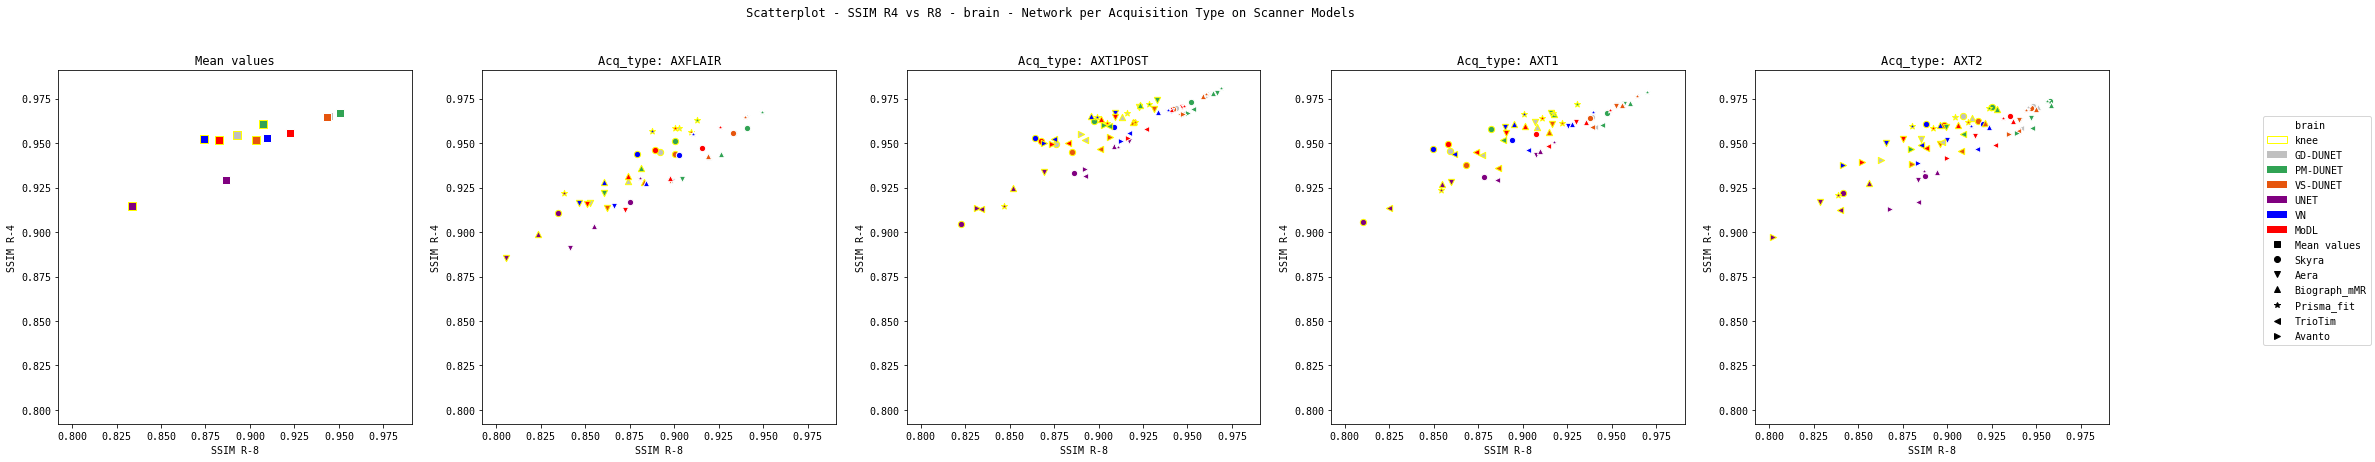

In [6]:
# New Version:

anatomy = 'brain'
eval_metric = 'SSIM'

x1, x2 = get_base_data_reval_comparison(anatomy, eval_metric)

eval_dset = ['neuro','knee 100'] # name of dataset in csv
disp_dset = ['neuro','knee'] # display name of dataset

df_raw_r4 = pd.read_csv(f'./resources/{anatomy}/eval_{anatomy}_R4.csv')
df_raw_r8 = pd.read_csv(f'./resources/{anatomy}/eval_{anatomy}_R8.csv')

networks = df_raw_r4.network.unique()
acq_types = df_raw_r4.acquisition.unique() #acquisition types: ['AXFLAIR', 'AXT1POST', 'AXT1', 'AXT2']
scanner_models = df_raw_r8.systemModel.unique() #scanner models: ['Skyra' 'Aera' 'Biograph_mMR' 'Prisma_fit' 'TrioTim' 'Avanto']
print(acq_types)

fig, axis = plt.subplots(1, len(acq_types) + 1, figsize=((len(acq_types)+1 + 0.25)*7, 7))

legend = get_legend(networks, scanner_models)
xlims = [get_xlim(eval_metric, x1, x2)]

for row in range(len(x1)):
    r4 = x1.loc[row][eval_metric]
    r8 = x2.loc[row][eval_metric]
    axis[0].scatter(r8, r4, s=75, marker=',', color=get_color([x1.loc[row]["network"]]), edgecolor=get_edge_color(x1.loc[row]["dset"]))
    axis[0].set_xlabel(f"{eval_metric} R-8")
    axis[0].set_ylabel(f"{eval_metric} R-4")
    axis[0].set_title(f'Mean values')
    axis[0].set_aspect('equal', adjustable='box')

for i, acq_type in enumerate(acq_types):
    i += 1

    df_r4_acq = df_raw_r4
    df_r4_acq = df_r4_acq[df_r4_acq.acquisition == acq_type]

    df_r8_acq = df_raw_r8
    df_r8_acq = df_r8_acq[df_r8_acq.acquisition == acq_type]

    for scanner_model in scanner_models:
        # get R4 data
        df_r4 = df_r4_acq
        df_r4 = df_r4[df_r4.systemModel == scanner_model]
        if not df_r4.empty:
            # evaluate wrt. SSIM and drop other measures
            drop_metric = [m for m in ['MSE', 'PSNR', 'NMSE', 'SSIM'] if m != eval_metric]
            df_r4 = df_r4.drop(columns=drop_metric)

            # drop rows that are not of the acquisition type
            #df = df[df.network == network_type]
            network_keys = df_r4['network'].unique()
            anatomy_keys = df_r4['anatomy'].unique()
            model_keys = df_r4['systemModel'].unique()
            # only evaluate for knee 100 (full fastMRI knee dataset) and neuro data (full fastMRI neuro dataset)
            anatomy_keys = [key for key in anatomy_keys if key in eval_dset]
            x3 = get_plotting_data_df(df_r4, network_keys, anatomy_keys, eval_metric, network_column='network')

            # get R8 data
            df_r8 = df_r8_acq
            df_r8 = df_r8[df_r8.systemModel == scanner_model]
            df_r8 = df_r8.drop(columns=drop_metric)
            x4 = get_plotting_data_df(df_r8, network_keys, anatomy_keys, eval_metric, network_column='network')

            # plot R4 and R8 data
            for row in range(len(x3)):
                r4 = x3.loc[row][eval_metric]
                r8 = x4.loc[row][eval_metric]

                axis[i].scatter(r8, r4, s=40, marker=get_marker(scanner_model), color=get_color([x3.loc[row]["network"]]), edgecolor=get_edge_color(x3.loc[row]["dset"]))
                axis[i].set_xlabel(f'{eval_metric} R-8')
                axis[i].set_ylabel(f'{eval_metric} R-4')
                axis[i].set_title(f'Acq_type: {acq_type}')
                axis[i].set_aspect('equal', adjustable='box')
            
            xlims.append(get_xlim(eval_metric, x3, x4))

# calculate axis values
xlims = np.array(xlims)
xlim = [min(xlims[:,0]), max(xlims[:,1])]

# Show scatterplot
fig.suptitle(f"Scatterplot - {eval_metric} R4 vs R8 - {anatomy} - Network per Acquisition Type on Scanner Models")
fig.legend(handles=legend, loc='center right')

# set common axis value for all subplot
for i in range(len(acq_types) + 1):
    axis[i].set_xlim(xlim)
    axis[i].set_ylim(xlim)

plt.show()

# Scatterplotting networks' performances per scanner models on acquisition types

['Skyra' 'Aera' 'Biograph_mMR' 'Prisma_fit' 'TrioTim' 'Avanto']


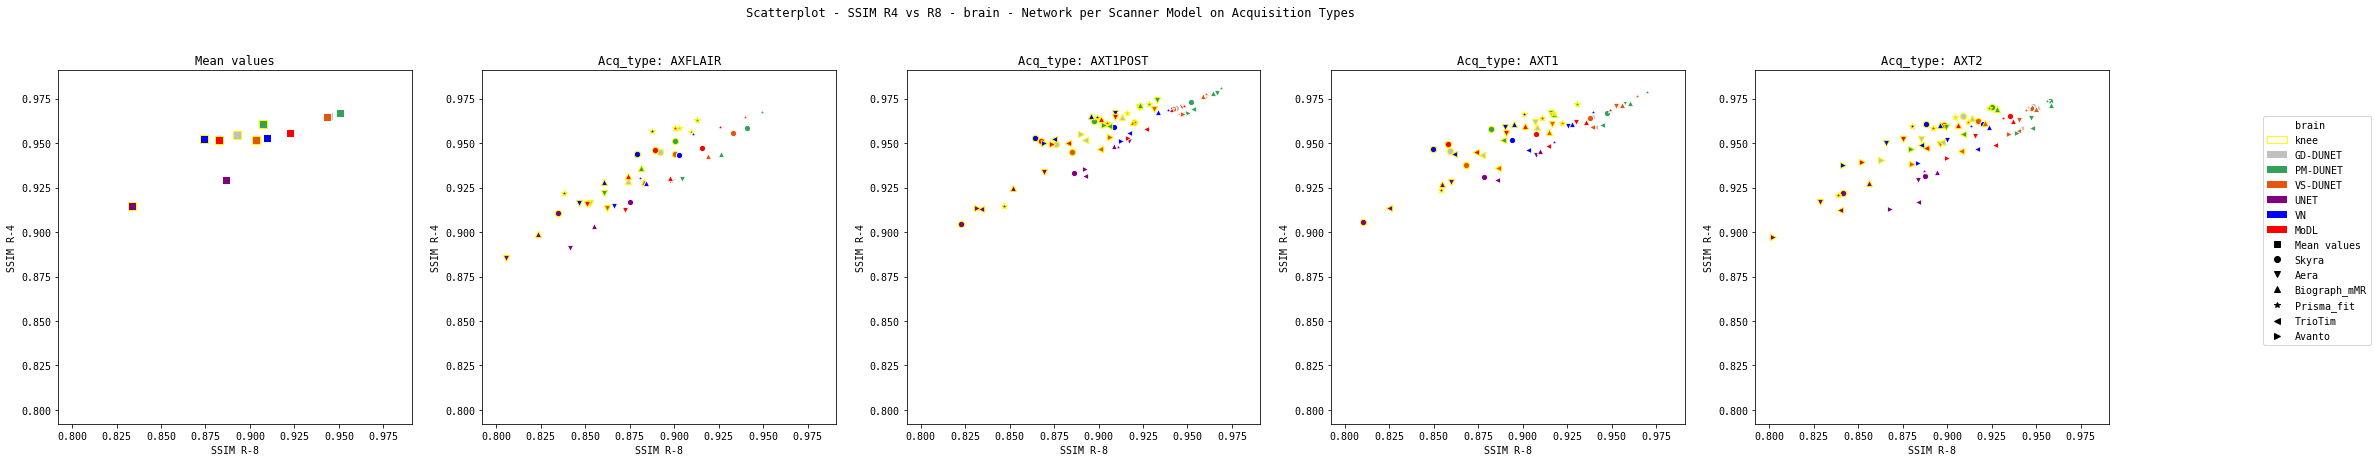

In [10]:
# New Version:

anatomy = 'brain'
eval_metric = 'SSIM'

x1, x2 = get_base_data_reval_comparison(anatomy, eval_metric)

eval_dset = ['neuro','knee 100'] # name of dataset in csv
disp_dset = ['neuro','knee'] # display name of dataset

df_raw_r4 = pd.read_csv(f'./resources/{anatomy}/eval_{anatomy}_R4.csv')
df_raw_r8 = pd.read_csv(f'./resources/{anatomy}/eval_{anatomy}_R8.csv')

networks = df_raw_r4.network.unique()
acq_types = df_raw_r4.acquisition.unique() #acquisition types: ['AXFLAIR', 'AXT1POST', 'AXT1', 'AXT2']
scanner_models = df_raw_r4.systemModel.unique() #scanner models: ['Skyra' 'Aera' 'Biograph_mMR' 'Prisma_fit' 'TrioTim' 'Avanto']
print(scanner_models)

fig, axis = plt.subplots(1, len(acq_types) + 1, figsize=((len(acq_types)+1 + 0.25)*7, 7))

legend = get_legend(networks, scanner_models)
xlims = [get_xlim(eval_metric, x1, x2)]

for row in range(len(x1)):
    r4 = x1.loc[row][eval_metric]
    r8 = x2.loc[row][eval_metric]
    axis[0].scatter(r8, r4, s=75, marker=',', color=get_color([x1.loc[row]["network"]]), edgecolor=get_edge_color(x1.loc[row]["dset"]))
    axis[0].set_xlabel(f"{eval_metric} R-8")
    axis[0].set_ylabel(f"{eval_metric} R-4")
    axis[0].set_title(f'Mean values')
    axis[0].set_aspect('equal', adjustable='box')

for i, scanner_model in enumerate(scanner_models):
    i += 1

    df_r4_acq = df_raw_r4
    df_r4_acq = df_r4_acq[df_r4_acq.systemModel == scanner_model]

    df_r8_acq = df_raw_r8
    df_r8_acq = df_r8_acq[df_r8_acq.systemModel == scanner_model]

    for acq_type in acq_types:
        # get R4 data
        df_r4 = df_r4_acq
        df_r4 = df_r4[df_r4.systemModel == scanner_model]
        if not df_r4.empty:
            # evaluate wrt. SSIM and drop other measures
            drop_metric = [m for m in ['MSE', 'PSNR', 'NMSE', 'SSIM'] if m != eval_metric]
            df_r4 = df_r4.drop(columns=drop_metric)

            # drop rows that are not of the acquisition type
            #df = df[df.network == network_type]
            network_keys = df_r4['network'].unique()
            anatomy_keys = df_r4['anatomy'].unique()
            model_keys = df_r4['systemModel'].unique()
            # only evaluate for knee 100 (full fastMRI knee dataset) and neuro data (full fastMRI neuro dataset)
            anatomy_keys = [key for key in anatomy_keys if key in eval_dset]
            x3 = get_plotting_data_df(df_r4, network_keys, anatomy_keys, eval_metric, network_column='network')

            # get R8 data
            df_r8 = df_r8_acq
            df_r8 = df_r8[df_r8.systemModel == scanner_model]
            df_r8 = df_r8.drop(columns=drop_metric)
            x4 = get_plotting_data_df(df_r8, network_keys, anatomy_keys, eval_metric, network_column='network')

            # plot R4 and R8 data
            for row in range(len(x3)):
                r4 = x3.loc[row][eval_metric]
                r8 = x4.loc[row][eval_metric]

                axis[i].scatter(r8, r4, s=40, marker=get_marker(scanner_model), color=get_color([x3.loc[row]["network"]]), edgecolor=get_edge_color(x3.loc[row]["dset"]))
                
                axis[i].set_xlabel(f"{eval_metric} R-8")
                axis[i].set_ylabel(f"{eval_metric} R-4")
                axis[i].set_title(f'Acq_type: {acq_type}')
                axis[i].set_aspect('equal', adjustable='box')
            
            xlims.append(get_xlim(eval_metric, x3, x4))

# calculate axis values
xlims = np.array(xlims)
xlim = [min(xlims[:,0]), max(xlims[:,1])]

# Show scatterplot
fig.suptitle(f"Scatterplot - {eval_metric} R4 vs R8 - {anatomy} - Network per Scanner Model on Acquisition Types")
fig.legend(handles=legend, loc='center right')

# set common axis value for all subplot
for i in range(len(acq_types) + 1):
    axis[i].set_xlim(xlim)
    axis[i].set_ylim(xlim)

plt.show()

# Scatterplotting one specific network's performance on scanner models

Plot: SSIM of a network with Reval = 4 vs Reval = 8 for all scanner models

In [5]:
def get_color_network(elems):
    cmap = plt.cm.tab20c
    color = []
    for elem in elems:
        if 'GD-DUNET' in elem:
            color.append("silver")
        elif 'PM-DUNET' in elem:
            color.append(cmap(2*4/20))
        elif 'VS-DUNET' in elem:
            color.append(cmap(1/5))
        elif 'UNET' in elem:
            color.append("purple")
        elif 'VN' in elem:
            color.append("blue")
        elif 'MoDL' in elem:
            color.append("red")
        else:
            color.append("black")

    return color


def get_legend_network(eval_dset, acq_types):
    legend_elements = []
    legend_elements.append(Patch(edgecolor="white", facecolor="white", label="brain"))
    legend_elements.append(Patch(edgecolor="yellow", facecolor="white", label="knee"))      
    color = get_color(eval_dset)
    # add network colors
    for c, l in zip(color, eval_dset):
        legend_elements.append(Patch(facecolor=c, label=l))
    # Add acquisition type markers
    legend_elements.append(mlines.Line2D([], [], color='black', marker="s", linestyle='None', label="Mean values")) 
    for acq_type in acq_types:
        legend_elements.append(mlines.Line2D([], [], color='black', marker=get_marker(acq_type), linestyle='None', label=acq_type))

    return legend_elements

     systemModel            dset      SSIM  SSIM_std
0     Skyra       knee 100        0.913956  0.029743
1     Skyra       neuro           0.953780  0.018128
2     Aera        knee 100        0.905953  0.037542
3     Aera        neuro           0.949158  0.026733
4   Biograph_mMR  knee 100        0.924262  0.017532
5   Biograph_mMR  neuro           0.957985  0.012093
6     Prisma_fit  knee 100        0.923520  0.021760
7     Prisma_fit  neuro           0.958365  0.016731
8     TrioTim     knee 100        0.903080  0.022824
9     TrioTim     neuro           0.948715  0.014547
10    Avanto      knee 100        0.887134  0.026194
11    Avanto      neuro           0.942912  0.015136
[0.8236296497809189, 0.9767140927504149]
['GD-DUNET', 'PM-DUNET', 'VS-DUNET', 'UNET', 'VN', 'MoDL']


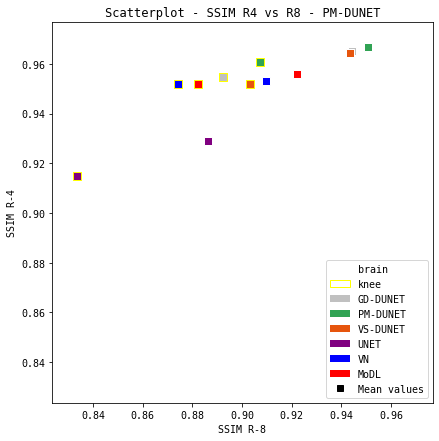

In [7]:
network_type = 'PM-DUNET'
anatomy = 'brain'

eval_metric = 'SSIM'
eval_dset = ['neuro','knee 100'] # name of dataset in csv
disp_dset = ['neuro','knee'] # display name of dataset

df_raw_r4 = pd.read_csv(f'./resources/{anatomy}/eval_{anatomy}_R4.csv')
df_raw_r8 = pd.read_csv(f'./resources/{anatomy}/eval_{anatomy}_R8.csv')

acq_types = df_raw_r4.acquisition.unique() #acquisition types: ['AXFLAIR', 'AXT1POST', 'AXT1', 'AXT2']
scanner_models = df_raw_r4.systemModel.unique() #scanner models: ['Skyra' 'Aera' 'Biograph_mMR' 'Prisma_fit' 'TrioTim' 'Avanto']

df = df_raw_r8
# evaluate wrt. SSIM and drop other measures
drop_metric = [m for m in ['MSE', 'PSNR', 'NMSE', 'SSIM'] if m != eval_metric]
df.drop(columns=drop_metric, inplace=True)

# drop rows that do not fufill requirement
df = df[df.network == network_type]

model_keys = df['systemModel'].unique()
anatomy_keys = df['anatomy'].unique()

# only evaluate for knee 100 (full fastMRI knee dataset) and neuro data (full fastMRI neuro dataset)
anatomy_keys = [key for key in anatomy_keys if key in eval_dset]

x = get_plotting_data_df(df, model_keys, anatomy_keys, eval_metric, network_column='systemModel')

print(x)

# --------------------------

eval_metric = "SSIM"

x1, x2 = get_base_data_reval_comparison("brain", eval_metric)

xlim = get_xlim(eval_metric, x1, x2)
print(xlim)

markers = ["." , "," , "o" , "v" , "^" , "<", ">"]

networks = [network.replace(" ", "") for network in x1.network.unique()]
print(networks)
legend = get_legend(networks, [])
cmap = plt.cm.tab20c

fig = plt.figure(figsize=(7, 7))

for row in range(len(x1)):
    r4 = x1.loc[row]["SSIM"]
    r8 = x2.loc[row]["SSIM"]
    plt.scatter(r8, r4, s=75, marker=',', color=get_color([x1.loc[row]["network"]]), edgecolor=get_edge_color(x1.loc[row]["dset"]))


plt.title(f"Scatterplot - {eval_metric} R4 vs R8 - {network_type}")
plt.xlabel("SSIM R-8")
plt.axis('square')
plt.ylabel("SSIM R-4")
plt.legend(handles=legend, loc='lower right')
plt.xlim(xlim)
plt.ylim(xlim)
plt.show()

# SSIM - anatomy = knee vs brain

Doesn't make sense to include both train_anatomies

In [6]:
def get_base_data_anatomy_comparison(eval_anatomy, Reval, eval_metric):

    eval_dset = ['neuro','knee 100'] # name of dataset in csv
    disp_dset = ['neuro','knee'] # display name of dataset

    df_raw = pd.read_csv(f'./resources/{eval_anatomy}/eval_{eval_anatomy}_R{Reval}.csv')

    networks = df_raw.network.unique()
    acq_types = df_raw.acquisition.unique() #acquisition types: ['AXFLAIR', 'AXT1POST', 'AXT1', 'AXT2']
    scanner_models = df_raw.systemModel.unique() #scanner models: ['Skyra' 'Aera' 'Biograph_mMR' 'Prisma_fit' 'TrioTim' 'Avanto']

    df = df_raw
    # evaluate wrt. SSIM and drop other measures
    drop_metric = [m for m in ['MSE', 'PSNR', 'NMSE', 'SSIM'] if m != eval_metric]
    df.drop(columns=drop_metric, inplace=True)

    # drop rows that are not of the acquisition type
    df = df[df.anatomy == 'neuro']
    network_keys = df['network'].unique()
    anatomy_keys = df['anatomy'].unique()
    model_keys = df['systemModel'].unique()
    
    # only evaluate for knee 100 (full fastMRI knee dataset) and neuro data (full fastMRI neuro dataset)
    anatomy_keys = [key for key in anatomy_keys if key in eval_dset]

    x1 = get_plotting_data_df(df, network_keys, anatomy_keys, eval_metric, network_column='network')
    
    df = df_raw
    df = df[df.anatomy == 'knee 100']
    anatomy_keys = df['anatomy'].unique()
    anatomy_keys = [key for key in anatomy_keys if key in eval_dset]

    x2 = get_plotting_data_df(df, network_keys, anatomy_keys, eval_metric, network_column='network')

    return x1, x2


def get_legend_anatomy_comparison(eval_dset, acq_types):
    legend_elements = []
    color = get_color(eval_dset)
    # add network colors
    for c, l in zip(color, eval_dset):
        legend_elements.append(Patch(facecolor=c, label=l))
    # Add acquisition type markers
    legend_elements.append(mlines.Line2D([], [], color='black', marker="s", linestyle='None', label="Mean values")) 
    for acq_type in acq_types:
        legend_elements.append(mlines.Line2D([], [], color='black', marker=get_marker(acq_type), linestyle='None', label=acq_type))

    return legend_elements

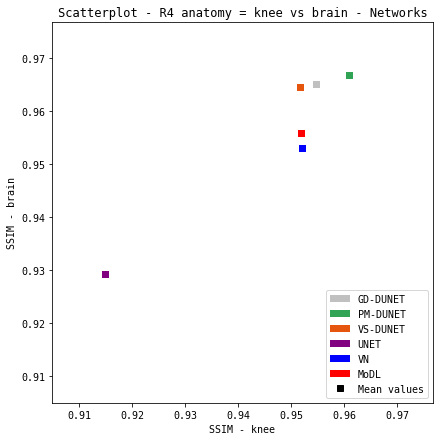

In [95]:
eval_metric = 'SSIM'
Reval = 4
eval_anatomy = 'brain'
x1, x2 = get_base_data_anatomy_comparison(eval_anatomy, Reval, eval_metric)

xlim = get_xlim(eval_metric, x1, x2)

networks = [network.replace(" ", "") for network in x1.network.unique()]
legend = get_legend_anatomy_comparison(networks, [])
cmap = plt.cm.tab20c

fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111)

for row in range(len(x1)):
    r_brain = x1.loc[row]["SSIM"]
    r_knee = x2.loc[row]["SSIM"]
    plt.scatter(r_knee, r_brain, s=75, marker=',', color=get_color([x1.loc[row]["network"]]), edgecolor=get_edge_color(x1.loc[row]["dset"]))

# Show scatterplot
plt.title(f"Scatterplot - R{Reval} anatomy = knee vs brain - Networks")
plt.axis('square')
plt.xlabel("SSIM - knee")
plt.ylabel("SSIM - brain")
plt.legend(handles=legend, loc='lower right')
plt.xlim(xlim)
plt.ylim(xlim)
plt.show()

# SSIM - anatomy = knee vs brain per acquisition types

['CORPDFS_FBK' 'CORPD_FBK']
      network            dset      SSIM  SSIM_std
0  GD-DUNET    knee 100        0.923251  0.024035
1  PM-DUNET    knee 100        0.930338  0.023409
2  VS-DUNET    knee 100        0.920868  0.024213
3  UNET        knee 100        0.875910  0.028267
4  VN          knee 100        0.887331  0.034644
5  MoDL        knee 100        0.897848  0.032192


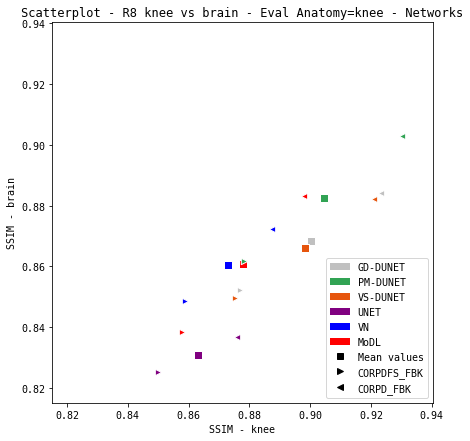

In [11]:
eval_metric = 'SSIM'
eval_anatomy = 'knee'
Reval = 8
x1, x2 = get_base_data_anatomy_comparison(eval_anatomy, Reval, eval_metric)

eval_dset = ['neuro','knee 100'] # name of dataset in csv
disp_dset = ['neuro','knee'] # display name of dataset

fig = plt.figure(figsize=(7, 7))

df_raw = pd.read_csv(f'./resources/{eval_anatomy}/eval_{eval_anatomy}_R{Reval}.csv')

networks = df_raw.network.unique()
acq_types = df_raw.acquisition.unique() #acquisition types: ['AXFLAIR', 'AXT1POST', 'AXT1', 'AXT2']
scanner_models = df_raw.systemModel.unique() #scanner models: ['Skyra' 'Aera' 'Biograph_mMR' 'Prisma_fit' 'TrioTim' 'Avanto']
print(acq_types)

legend = get_legend_anatomy_comparison(networks, acq_types)
xlims = [get_xlim(eval_metric, x1, x2)]

for row in range(len(x1)):
    r4 = x1.loc[row][eval_metric]
    r8 = x2.loc[row][eval_metric]
    plt.scatter(r8, r4, s=75, marker=',', color=get_color([x1.loc[row]["network"]]), edgecolor=get_edge_color(x1.loc[row]["dset"]))

for acq_type in acq_types:
    df_anatomy = df_raw
    df_anatomy = df_anatomy[df_anatomy.acquisition == acq_type]

    # evaluate wrt. SSIM and drop other measures
    drop_metric = [m for m in ['MSE', 'PSNR', 'NMSE', 'SSIM'] if m != eval_metric]
    df_anatomy = df_anatomy.drop(columns=drop_metric)
    df = df_anatomy

    # drop rows that are not of the acquisition type
    df = df[df.anatomy == 'neuro']
    network_keys = df['network'].unique()
    anatomy_keys = df['anatomy'].unique()
    model_keys = df['systemModel'].unique()
    # only evaluate for knee 100 (full fastMRI knee dataset) and neuro data (full fastMRI neuro dataset)
    anatomy_keys = [key for key in anatomy_keys if key in eval_dset]

    x3 = get_plotting_data_df(df, network_keys, anatomy_keys, eval_metric, network_column='network')
    
    df = df_anatomy
    df = df[df.anatomy == 'knee 100']
    anatomy_keys = df['anatomy'].unique()
    network_keys = df['network'].unique()
    anatomy_keys = [key for key in anatomy_keys if key in eval_dset]

    x4 = get_plotting_data_df(df, network_keys, anatomy_keys, eval_metric, network_column='network')


    # plot R4 and R8 data
    for row in range(len(x3)):
        r4 = x3.loc[row][eval_metric]
        r8 = x4.loc[row][eval_metric]
        plt.scatter(r8, r4, s=40, marker=get_marker(acq_type), color=get_color([x3.loc[row]["network"]]), edgecolor=get_edge_color(x3.loc[row]["dset"]))
    xlims.append(get_xlim(eval_metric, x3, x4))

print(x4)

# calculate axis values
xlims = np.array(xlims)
xlim = [min(xlims[:,0]), max(xlims[:,1])]

# Show scatterplot
plt.title(f"Scatterplot - R{Reval} knee vs brain - Eval Anatomy={eval_anatomy} - Networks")
plt.axis('square')
plt.xlabel("SSIM - knee")
plt.ylabel("SSIM - brain")
plt.legend(handles=legend, loc='lower right')
plt.xlim(xlim)
plt.ylim(xlim)
plt.show()

# SSIM - anatomy = knee vs brain per acquisition types for both eval_anatomies

Note: SSIM values on x-/y-axis are Training datasets (dset parameter in csv files), acq_types with colored border in plot are Evaluation dataset types (csv files)

['AXFLAIR' 'AXT1POST' 'AXT1' 'AXT2']
['CORPDFS_FBK' 'CORPD_FBK']


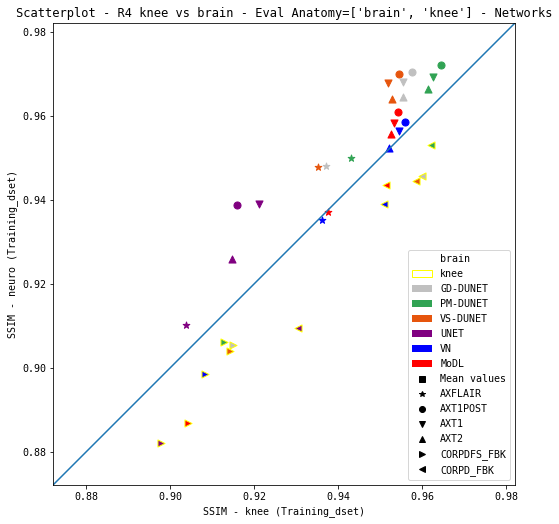

In [19]:
# Mean values removed
eval_metric = 'SSIM'
Reval = 4

eval_dset = ['neuro','knee 100'] # name of dataset in csv
disp_dset = ['neuro','knee'] # display name of dataset
eval_file = ['brain','knee']

fig = plt.figure(figsize=(8.5, 8.5))

#df_raw_brain = pd.read_csv(f'./resources/brain/eval_brain_R{Reval}.csv')
#df_raw_knee = pd.read_csv(f'./resources/knee/eval_knee_R{Reval}.csv')

networks = df_raw_brain.network.unique()
all_acq_types = []
xlims = []

for eval_anatomy in eval_file:
    df_raw = pd.read_csv(f'./resources/{eval_anatomy}/eval_{eval_anatomy}_R{Reval}.csv')
    acq_types = df_raw.acquisition.unique() 
    print(acq_types)
    all_acq_types += list(acq_types)

    for acq_type in acq_types:
        df_anatomy = df_raw
        df_anatomy = df_anatomy[df_anatomy.acquisition == acq_type]

        # evaluate wrt. SSIM and drop other measures
        drop_metric = [m for m in ['MSE', 'PSNR', 'NMSE', 'SSIM'] if m != eval_metric]
        df_anatomy = df_anatomy.drop(columns=drop_metric)
        
        df = df_anatomy
        # drop rows that are not of the acquisition type
        df = df[df.anatomy == 'neuro']
        network_keys = df['network'].unique()
        anatomy_keys = df['anatomy'].unique()
        model_keys = df['systemModel'].unique()
        # only evaluate for knee 100 (full fastMRI knee dataset) and neuro data (full fastMRI neuro dataset)
        anatomy_keys = [key for key in anatomy_keys if key in eval_dset]

        x3 = get_plotting_data_df(df, network_keys, anatomy_keys, eval_metric, network_column='network')
        
        df = df_anatomy
        df = df[df.anatomy == 'knee 100']
        anatomy_keys = df['anatomy'].unique()
        network_keys = df['network'].unique()
        anatomy_keys = [key for key in anatomy_keys if key in eval_dset]

        x4 = get_plotting_data_df(df, network_keys, anatomy_keys, eval_metric, network_column='network')

        # plot R4 and R8 data
        for row in range(len(x3)):
            r4 = x3.loc[row][eval_metric]
            r8 = x4.loc[row][eval_metric]
            plt.scatter(r8, r4, s=50, marker=get_marker(acq_type), color=get_color([x3.loc[row]["network"]]), edgecolor=get_edge_color(eval_anatomy))
        xlims.append(get_xlim(eval_metric, x3, x4))

legend = get_legend(networks, all_acq_types)

# calculate axis values
xlims = np.array(xlims)
xlim = [min(xlims[:,0]), max(xlims[:,1])]

# draw line y = x
plt.axline((xlim[0], xlim[0]), (xlim[1], xlim[1]))

# Show scatterplot
plt.title(f"Scatterplot - R{Reval} knee vs brain - Eval Anatomy={eval_file} - Networks")
plt.axis('square')
plt.xlabel("SSIM - knee (Training_dset)")
plt.ylabel("SSIM - neuro (Training_dset)")
plt.legend(handles=legend, loc='lower right')
plt.xlim(xlim)
plt.ylim(xlim)
plt.show()

Both R4 and R8:

['AXFLAIR' 'AXT1POST' 'AXT1' 'AXT2']


<ipython-input-26-3ba72c895221>:48: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  metric_mean = df_eval[df_eval['anatomy']==ecol].mean()[eval_metric]
<ipython-input-26-3ba72c895221>:49: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  metric_std = df_eval[df_eval['anatomy']==ecol].std()[eval_metric]


['CORPDFS_FBK' 'CORPD_FBK']
['AXFLAIR' 'AXT1POST' 'AXT1' 'AXT2']
['CORPDFS_FBK' 'CORPD_FBK']


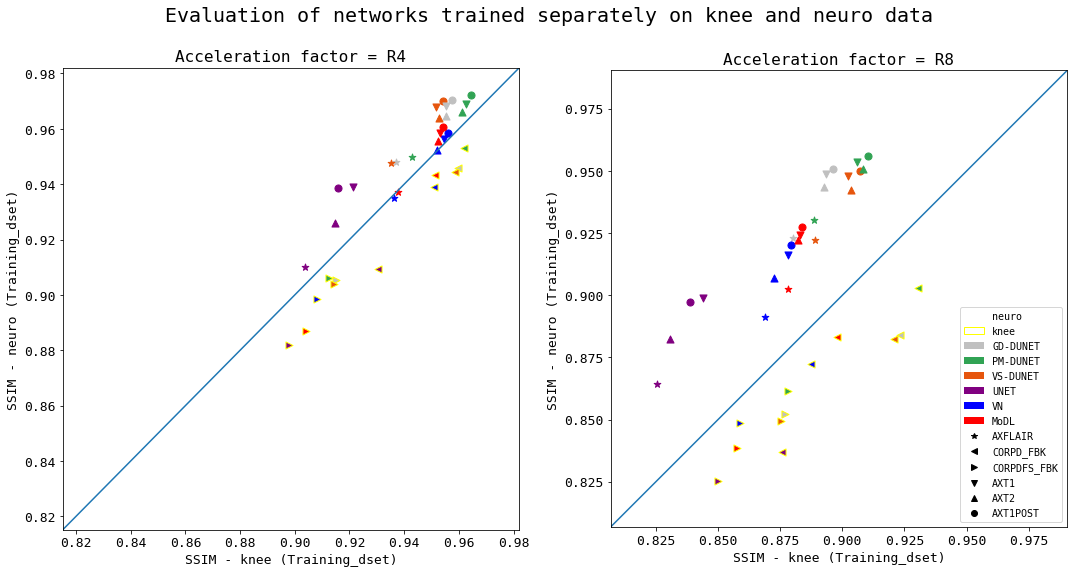

In [27]:
#plt.rcParams["font.size"] = 10
plt.rcParams["xtick.labelsize"] = 13
plt.rcParams["ytick.labelsize"] = 13
plt.rcParams["axes.titlesize"] = 13
plt.rcParams['axes.labelsize'] = 13
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['figure.titlesize'] = 20

# Mean values removed
eval_metric = 'SSIM'

eval_dset = ['neuro','knee 100'] # name of dataset in csv
disp_dset = ['neuro','knee'] # display name of dataset
eval_file = ['brain','knee']

#fig = plt.figure(figsize=(8.5, 8.5))
fig, axis = plt.subplots(1, 2, figsize=(18, 8.5))

Revals = [4, 8]

#df_raw_brain = pd.read_csv(f'./resources/brain/eval_brain_R{Reval}.csv')
#df_raw_knee = pd.read_csv(f'./resources/knee/eval_knee_R{Reval}.csv')


#networks = df_raw_brain.network.unique()
all_acq_types = []
xlims = []

for i, Reval in enumerate(Revals):
    for eval_anatomy in eval_file:
        df_raw = pd.read_csv(f'./resources/{eval_anatomy}/eval_{eval_anatomy}_R{Reval}.csv')
        acq_types = df_raw.acquisition.unique() 
        print(acq_types)
        all_acq_types += list(acq_types)

        for acq_type in acq_types:
            df_anatomy = df_raw
            df_anatomy = df_anatomy[df_anatomy.acquisition == acq_type]

            # evaluate wrt. SSIM and drop other measures
            drop_metric = [m for m in ['MSE', 'PSNR', 'NMSE', 'SSIM'] if m != eval_metric]
            df_anatomy = df_anatomy.drop(columns=drop_metric)
            
            df = df_anatomy
            # drop rows that are not of the acquisition type
            df = df[df.anatomy == 'neuro']
            network_keys = df['network'].unique()
            anatomy_keys = df['anatomy'].unique()
            model_keys = df['systemModel'].unique()
            # only evaluate for knee 100 (full fastMRI knee dataset) and neuro data (full fastMRI neuro dataset)
            anatomy_keys = [key for key in anatomy_keys if key in eval_dset]

            x3 = get_plotting_data_df(df, network_keys, anatomy_keys, eval_metric, network_column='network')
            
            df = df_anatomy
            df = df[df.anatomy == 'knee 100']
            anatomy_keys = df['anatomy'].unique()
            network_keys = df['network'].unique()
            anatomy_keys = [key for key in anatomy_keys if key in eval_dset]

            x4 = get_plotting_data_df(df, network_keys, anatomy_keys, eval_metric, network_column='network')

            # plot R4 and R8 data
            for row in range(len(x3)):
                r4 = x3.loc[row][eval_metric]
                r8 = x4.loc[row][eval_metric]
                axis[i].scatter(r8, r4, s=50, marker=get_marker(acq_type), color=get_color([x3.loc[row]["network"]]), edgecolor=get_edge_color(eval_anatomy))
            xlims.append(get_xlim(eval_metric, x3, x4))

all_acq_types = list(set(all_acq_types))
legend = get_legend(network_keys, all_acq_types)

# calculate axis values
xlims = np.array(xlims)
xlim = [min(xlims[:,0]), max(xlims[:,1])]

for i, Reval in enumerate(Revals):
    # draw line y = x
    axis[i].axline((xlim[0], xlim[0]), (xlim[1], xlim[1]))
    axis[i].set_xlim(xlim)
    axis[i].set_ylim(xlim)
    axis[i].set_xlabel("SSIM - knee (Training_dset)")
    axis[i].set_ylabel("SSIM - neuro (Training_dset)")
    axis[i].set_title(f"Acceleration factor = R{Reval}")

# Show scatterplot
#plt.suptitle(f"Scatterplot - R{Reval} knee vs brain - Eval Anatomy={eval_file} - Networks")
plt.suptitle("Evaluation of networks trained separately on knee and neuro data")
plt.axis('square')
plt.legend(handles=legend, loc='lower right')
plt.show()

# SSIM - anatomy = knee vs brain per Scanner model

['GD-DUNET' 'PM-DUNET' 'VS-DUNET' 'UNET' 'VN' 'MoDL']
['Prisma_fit' 'Skyra' 'Aera' 'Biograph_mMR']


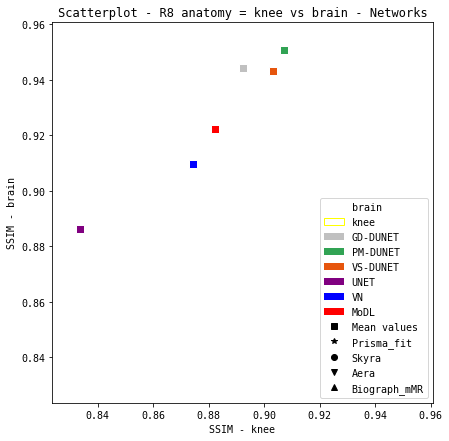

In [7]:
eval_metric = 'SSIM'
eval_anatomy = 'brain'
Reval = 8
x1, x2 = get_base_data_anatomy_comparison(eval_anatomy, Reval, eval_metric)
xlim = get_xlim(eval_metric, x1, x2)

eval_dset = ['neuro','knee 100'] # name of dataset in csv
disp_dset = ['neuro','knee'] # display name of dataset

fig = plt.figure(figsize=(7, 7))

df_raw_brain = pd.read_csv(f'./resources/brain/eval_brain_R{Reval}.csv')
df_raw_knee = pd.read_csv(f'./resources/knee/eval_knee_R{Reval}.csv')

networks = df_raw_brain.network.unique()
acq_types = df_raw_brain.acquisition.unique() #acquisition types: ['AXFLAIR', 'AXT1POST', 'AXT1', 'AXT2']
# using scanner models from anatomy=knee, anatomy=brain has more scanner models
scanner_models = df_raw_knee.systemModel.unique() #scanner models: ['Skyra' 'Aera' 'Biograph_mMR' 'Prisma_fit' 'TrioTim' 'Avanto']
print(networks)
print(scanner_models)

legend = get_legend(networks, scanner_models)

for row in range(len(x1)):
    r4 = x1.loc[row][eval_metric]
    r8 = x2.loc[row][eval_metric]
    plt.scatter(r8, r4, s=75, marker=',', color=get_color([x1.loc[row]["network"]]), edgecolor=get_edge_color(x1.loc[row]["dset"]))

"""for scanner_model in scanner_models:
    # get R4 data
    df_brain = df_raw_brain
    df_brain = df_brain[df_brain.systemModel == scanner_model]

    # evaluate wrt. SSIM and drop other measures
    drop_metric = [m for m in ['MSE', 'PSNR', 'NMSE', 'SSIM'] if m != eval_metric]
    df_brain = df_brain.drop(columns=drop_metric)

    # drop rows that are not of the acquisition type
    #df = df[df.network == network_type]
    network_keys = df_brain['network'].unique()
    anatomy_keys = df_brain['anatomy'].unique()
    model_keys = df_brain['systemModel'].unique()
    # only evaluate for knee 100 (full fastMRI knee dataset) and neuro data (full fastMRI neuro dataset)
    anatomy_keys = [key for key in anatomy_keys if key in eval_dset]
    x3 = get_plotting_data_df(df_brain, network_keys, anatomy_keys, eval_metric, network_column='network')

    # get R8 data
    df_knee = df_raw_knee
    df_knee = df_knee[df_knee.systemModel == scanner_model]
    df_knee = df_knee.drop(columns=drop_metric)
    x4 = get_plotting_data_df(df_knee, network_keys, anatomy_keys, eval_metric, network_column='network')

    # plot R4 and R8 data
    for row in range(len(x3)):
        r4 = x3.loc[row][eval_metric]
        r8 = x4.loc[row][eval_metric]
        plt.scatter(r8, r4, s=40, marker=get_marker(scanner_model), color=get_color([x3.loc[row]["network"]]), edgecolor=get_edge_color(x3.loc[row]["dset"]))"""

# Show scatterplot
plt.title(f"Scatterplot - R{Reval} anatomy = knee vs brain - Networks")
plt.axis('square')
plt.xlabel("SSIM - knee")
plt.ylabel("SSIM - brain")
plt.legend(handles=legend, loc='lower right')
plt.xlim(xlim)
plt.ylim(xlim)
plt.show()

# ---------- tests: ----------

In [14]:
# Modified version 
def get_plotting_data1(df, network_keys, anatomy_keys, eval_metric, network_column):
    df_final = None
    cols = [network_column, 'dset', eval_metric, eval_metric+'_std']
    for nkey in network_keys:
        for ecol in anatomy_keys:
            df_eval = df[df[network_column]==nkey]
            row = [f'{nkey.ljust(10)}', f'{ecol.ljust(14)}']
            count = df_eval[df_eval['anatomy']==ecol].count()[eval_metric]
            metric_mean = df_eval[df_eval['anatomy']==ecol].mean()[eval_metric]
            metric_std = df_eval[df_eval['anatomy']==ecol].std()[eval_metric]
            row.append(metric_mean)
            row.append(metric_std)

            df_eval = pd.DataFrame([row], columns=cols)
            df_final = pd.concat([df_final, df_eval], ignore_index=True)
            x = df_final
            x = df_final.set_index(network_column)[eval_metric]#.sort_values(ascending=True)
            y = df_final.set_index('dset')[eval_metric].sort_values(ascending=True)

    return x, y

In [15]:
anatomy = 'brain'
Reval = [4, 8]

eval_metric = 'SSIM'
eval_dset = ['neuro','knee 100'] # name of dataset in csv
disp_dset = ['neuro','knee'] # display name of dataset

df_raw = pd.read_csv(f'./resources/{anatomy}/eval_{anatomy}_R4.csv')

networks = df_raw.network.unique()
print(networks)

acq_types = df_raw.acquisition.unique() #acquisition types: ['AXFLAIR', 'AXT1POST', 'AXT1', 'AXT2']
scanner_models = df_raw.systemModel.unique() #scanner models: ['Skyra' 'Aera' 'Biograph_mMR' 'Prisma_fit' 'TrioTim' 'Avanto']

df = df_raw
# evaluate wrt. SSIM and drop other measures
drop_metric = [m for m in ['MSE', 'PSNR', 'NMSE', 'SSIM'] if m != eval_metric]
df.drop(columns=drop_metric, inplace=True)

# drop rows that are not of the acquisition type
#df = df[df.network == network_type]

network_keys = df['network'].unique()
anatomy_keys = df['anatomy'].unique()
# only evaluate for knee 100 (full fastMRI knee dataset) and neuro data (full fastMRI neuro dataset)
anatomy_keys = [key for key in anatomy_keys if key in eval_dset]

x1, _ = get_plotting_data1(df, network_keys, anatomy_keys, eval_metric, network_column='network')
print(x1)


df_raw = pd.read_csv(f'./resources/{anatomy}/eval_{anatomy}_R8.csv')
df = df_raw
model_keys = df['systemModel'].unique()
df.drop(columns=drop_metric, inplace=True)

x2, _ = get_plotting_data1(df, network_keys, anatomy_keys, eval_metric, network_column='network')
print(x2)

['GD-DUNET' 'PM-DUNET' 'VS-DUNET' 'UNET' 'VN' 'MoDL']
network
GD-DUNET      0.954599
GD-DUNET      0.965035
PM-DUNET      0.960833
PM-DUNET      0.966714
VS-DUNET      0.951747
VS-DUNET      0.964515
UNET          0.914880
UNET          0.929132
VN            0.952069
VN            0.952906
MoDL          0.951863
MoDL          0.955808
Name: SSIM, dtype: float64
network
GD-DUNET      0.892522
GD-DUNET      0.944308
PM-DUNET      0.907102
PM-DUNET      0.950715
VS-DUNET      0.903120
VS-DUNET      0.943298
UNET          0.833630
UNET          0.886339
VN            0.874398
VN            0.909779
MoDL          0.882405
MoDL          0.922269
Name: SSIM, dtype: float64
